# Imports

In [53]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# Initialize the Autoencoder variables and hyperparameters

In [54]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

batch_size = 512

# Load the data

### Replace this with ExtraSensory dataset

In [55]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

input_shape = 784
input_shape_len = 28   # one "side" of the image square

In [56]:
# For unsupervised learning, we just need the features (x), not the end result (y).
# Say the training data is [60000, 28, 28]. To make it 2-dimensional, we can
# multiply 28 * 28 = 784 and store that as a flattened image.

# Now the dataset is [60000, 784].

# For our project, we can do something similar... although it seems odd to make
# the linear time data into a square, only to flatten it back out again.

# Create an autoencoder class

In [57]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128)
        
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128)
        
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128)
        
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"])

    def forward(self, features):
        
        #Encoder 
        features = self.encoder_hidden_layer(features)
        features = torch.relu(features)
        
        features = self.encoder_output_layer(features)
        features = torch.relu(features)
        
        #Decoder
        features = self.decoder_hidden_layer(features)
        features = torch.relu(features)
        
        features = self.decoder_output_layer(features)
        features = torch.relu(features)
        
        return features

# Create an autoencoder instance

In [96]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder(input_shape = input_shape).to(device)

# Loss = Mean Squared Error
criterion = nn.MSELoss()

# Train the autoencoder

### Fit method accepts `num_epochs` as a parameter

In [97]:
def fit(num_epochs, learn_rate):
    loss_array = []
    
    # create an optimizer object
    # Adam optimizer with learning rate
    optimizer = optim.Adam(model.parameters(), lr = learn_rate)
    
    for epoch in range(num_epochs):
        loss = 0
        for batch_features, _ in train_loader:
            # reshape mini-batch data to [N, input_shape] matrix
            # load it to the active device
            batch_features = batch_features.view(-1, input_shape).to(device)

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            outputs = model(batch_features)

            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the average training loss across the epoch
        loss = loss / len(train_loader)
        loss_array.append(loss)

        # display the epoch training loss
        # print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
    return loss_array

In [98]:
loss_results = fit(num_epochs = 20, learn_rate = 1e-3)

### Visualize how loss changes with # epochs for training data

No handles with labels found to put in legend.


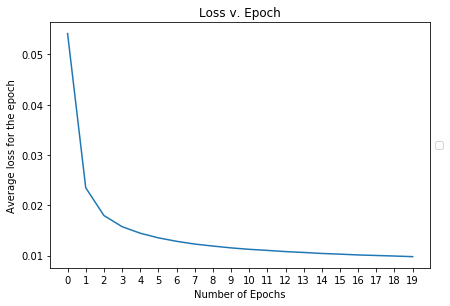

In [99]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.tight_layout()
ax1.plot(loss_results)
plt.xticks([x for x in range(20)])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Number of Epochs")
plt.ylabel("Average loss for the epoch")
plt.title("Loss v. Epoch")
plt.show()

# Test the dataset

In [100]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, input_shape)
        reconstruction = model(test_examples)
        break

# Illustrate the results

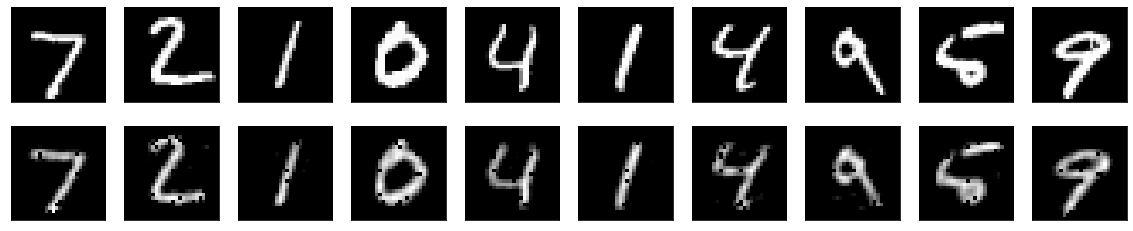

In [65]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(input_shape_len, input_shape_len))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(input_shape_len, input_shape_len))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

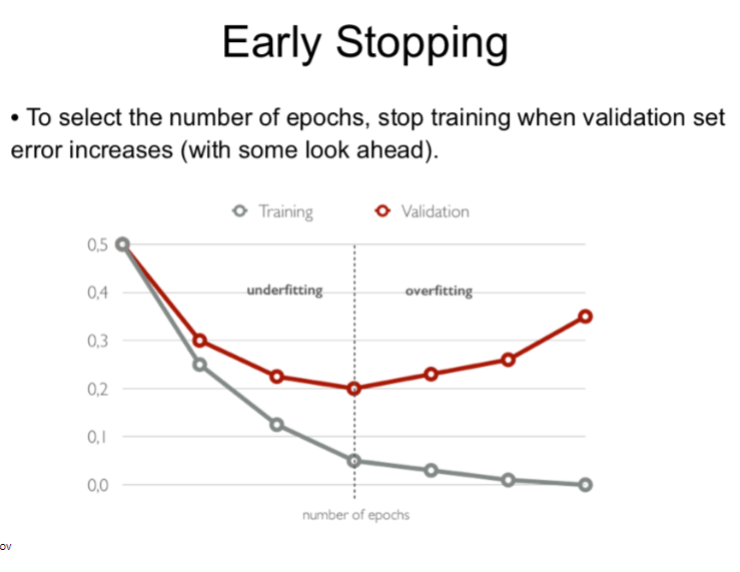

In [72]:
from IPython.display import Image
Image("graph_from_class.png")